In [1]:
import mne
import pickle

In [2]:
with open('bcci_data_preprocessed.pkl','rb') as f:
    dataset=pickle.load(f)

print("Preprocessed data has been loaded from 'bcci_data_preprocessed.pkl'")

C:\Users\dyuti\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Preprocessed data has been loaded from 'bcci_data_preprocessed.pkl'


In [3]:
input_window_samples = 1000

In [4]:
import torch

from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))
# Extract number of chans from dataset
n_chans = dataset[0][0].shape[0]

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length=30,
    drop_prob=0.7
)

# Display torchinfo table describing the model
print(model)

# Send model to GPU
if cuda:
    _ = model.cuda()

C:\Users\dyuti\anaconda3\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\dyuti\anaconda3\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 23, 1000]             [1, 4, 32]                --                        --
├─Ensure4d (ensuredims): 1-1             [1, 23, 1000]             [1, 23, 1000, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 23, 1000, 1]          [1, 1, 1000, 23]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1000, 23]          [1, 40, 976, 1]           37,840                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 976, 1]           [1, 40, 976, 1]           80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 976, 1]           [1, 40, 976, 1]           --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 976, 1]           [1, 40, 61, 1]            --                        [75, 1]
├─Express

In [5]:
model.to_dense_prediction_model()

In [6]:
n_preds_per_input = model.get_output_shape()[2]

In [7]:
from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])

# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    preload=True
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


In [8]:
splitted = windows_dataset.split('session')
train_set = splitted['0train']  # Session train
valid_set = splitted['1test'] 

In [9]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
from braindecode.training import CroppedLoss

lr = 0.0625 * 0.01
weight_decay = 0
batch_size=64
n_epochs=30

In [29]:
clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
_ = clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr       dur
-------  ----------------  ------------  ----------------  ------------  ------  --------
      1            0.6289        1.0277            0.5100        1.2167  0.0006  132.2549
      2            0.6917        0.9917            0.5544        1.1613  0.0006  135.5801
      3            0.7230        0.9953            0.5829        1.0942  0.0006  141.3640
      4            0.7234        1.0067            0.5891        1.0906  0.0006  123.0981
      5            0.6829        0.9811            0.5818        1.1256  0.0006  131.8999
      6            0.7450        0.9707            0.5760        1.0732  0.0006  140.4599
      7            0.6427        0.9752            0.5262        1.1096  0.0006  121.0693
      8            0.7257        0.9635            0.5864        1.0947  0.0005  147.6701
      9            0.7137        0.9791            0.5918        1.1038  0.0005  140.8963
     10   

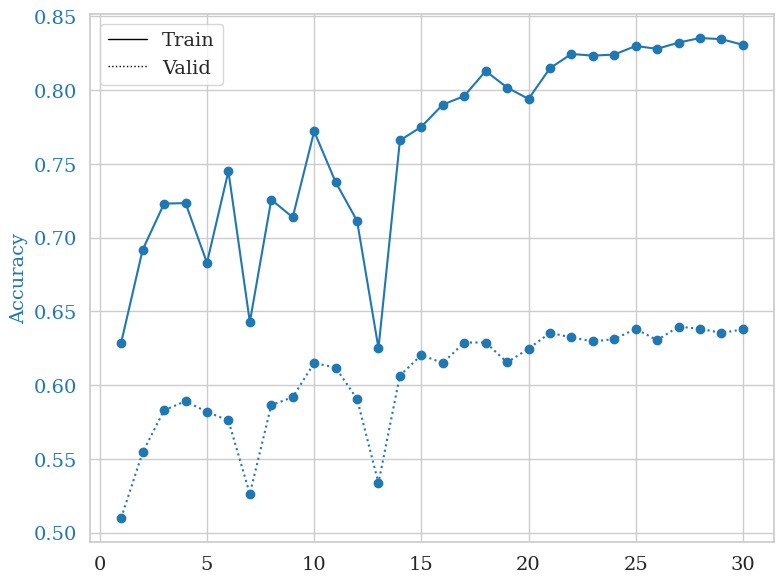

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy',
                   'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

fig, ax1 = plt.subplots(figsize=(8,6))
df.loc[:, ['train_accuracy', 'valid_accuracy']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False,
    fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Accuracy", color='tab:blue', fontsize=14)
handles = []
handles.append(
    Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(
    Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

In [1]:
import joblib

In [2]:
file1='Ablation_Shallow_Original.sav'

In [33]:
joblib.dump(clf,file1)

['Ablation_Shallow_Original.sav']

In [3]:
clf_original=joblib.load(file1)

C:\Users\dyuti\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\dyuti\anaconda3\Lib\site-packages\skorch\net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the 

## Ablation Study

#### 1. No batch Normalization

In [21]:
model_no_batch=ShallowFBCSPNet(
n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length=30,
    batch_norm= False,
    drop_prob=0.7
)
print(model)

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 23, 1000]             [1, 4, 467]               --                        --
├─Ensure4d (ensuredims): 1-1             [1, 23, 1000]             [1, 23, 1000, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 23, 1000, 1]          [1, 1, 1000, 23]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1000, 23]          [1, 40, 976, 1]           37,840                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 976, 1]           [1, 40, 976, 1]           80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 976, 1]           [1, 40, 976, 1]           --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 976, 1]           [1, 40, 902, 1]           --                        [75, 1]
├─Express

C:\Users\dyuti\anaconda3\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\dyuti\anaconda3\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [14]:
clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
_ = clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr      dur
-------  ----------------  ------------  ----------------  ------------  ------  -------
      1            0.2724        6.6788            0.2631        1.4053  0.0006  37.7306
      2            0.2708        1.4753            0.2859        1.3913  0.0006  33.7809
      3            0.2762        1.4202            0.2720        1.3852  0.0006  33.7939
      4            0.2658        1.4077            0.2693        1.3864  0.0006  33.9584
      5            0.2704        1.4006            0.2739        1.3864  0.0006  34.0458
      6            0.2720        1.3960            0.2627        1.3810  0.0006  33.8240
      7            0.2704        1.3940            0.2782        1.3805  0.0006  33.9954
      8            0.2674        1.3902            0.2639        1.3864  0.0005  26.5847
      9            0.2677        1.3890            0.2608        1.3818  0.0005  24.2828
     10            0.

In [4]:
file2='shallow_clf_no_batch_norm.sav'

In [16]:
joblib.dump(clf,file2)

['shallow_clf_no_batch_norm.sav']

In [5]:
clf_no_batch_norm=joblib.load(file2)

C:\Users\dyuti\anaconda3\Lib\site-packages\skorch\net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


#### 2. No Dropout Regularization

In [22]:
model_no_dropout=ShallowFBCSPNet(
n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length=30,
    drop_prob=0.0
)
print(model)

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 23, 1000]             [1, 4, 467]               --                        --
├─Ensure4d (ensuredims): 1-1             [1, 23, 1000]             [1, 23, 1000, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 23, 1000, 1]          [1, 1, 1000, 23]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1000, 23]          [1, 40, 976, 1]           37,840                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 976, 1]           [1, 40, 976, 1]           80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 976, 1]           [1, 40, 976, 1]           --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 976, 1]           [1, 40, 902, 1]           --                        [75, 1]
├─Express

In [21]:
clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
_ = clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr      dur
-------  ----------------  ------------  ----------------  ------------  ------  -------
      1            0.3873        1.4133            0.3657        1.3717  0.0006  21.1188
      2            0.3970        1.2951            0.3592        1.3608  0.0006  21.0482
      3            0.5139        1.2318            0.4703        1.2497  0.0006  23.2382
      4            0.5031        1.1953            0.4610        1.2686  0.0006  25.6378
      5            0.4873        1.1547            0.4437        1.2943  0.0006  26.0293
      6            0.4977        1.1498            0.4599        1.2569  0.0006  30.7668
      7            0.5683        1.1065            0.5228        1.2027  0.0006  24.1946
      8            0.5914        1.0919            0.5309        1.1849  0.0005  24.3838
      9            0.5880        1.0683            0.5096        1.1804  0.0005  27.0818
     10            0.

In [6]:
file3='shallow_no_dropout.sav'

In [23]:
joblib.dump(clf,file3)

['shallow_no_dropout.sav']

In [7]:
clf_no_dropout=joblib.load(file3)

C:\Users\dyuti\anaconda3\Lib\site-packages\skorch\net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


#### 3.No batch norm and dropout

In [23]:
model_no_both=ShallowFBCSPNet(
n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length=30,
    batch_norm=False,
    drop_prob=0.0
)
print(model)

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 23, 1000]             [1, 4, 467]               --                        --
├─Ensure4d (ensuredims): 1-1             [1, 23, 1000]             [1, 23, 1000, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 23, 1000, 1]          [1, 1, 1000, 23]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1000, 23]          [1, 40, 976, 1]           37,840                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 976, 1]           [1, 40, 976, 1]           80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 976, 1]           [1, 40, 976, 1]           --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 976, 1]           [1, 40, 902, 1]           --                        [75, 1]
├─Express

In [25]:
clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
_ = clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr      dur
-------  ----------------  ------------  ----------------  ------------  ------  -------
      1            0.2971        2.3337            0.3009        1.4976  0.0006  20.4855
      2            0.2921        1.4838            0.2982        1.5064  0.0006  24.5094
      3            0.3229        1.5049            0.3221        1.3915  0.0006  24.0567
      4            0.3727        1.3984            0.3468        1.3712  0.0006  22.9121
      5            0.3634        1.4459            0.3465        1.3409  0.0006  24.8329
      6            0.3453        1.4061            0.3619        1.4180  0.0006  24.5131
      7            0.3746        1.4050            0.3792        1.3644  0.0006  23.2549
      8            0.3866        1.3883            0.3669        1.3901  0.0005  23.2363
      9            0.3958        1.3829            0.3877        1.3417  0.0005  24.4800
     10            0.

In [8]:
file4='shallow_clf_no_both.sav'

In [27]:
joblib.dump(clf,file4)

['shallow_clf_no_both.sav']

In [9]:
clf_no_both=joblib.load(file4)

C:\Users\dyuti\anaconda3\Lib\site-packages\skorch\net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


### Visualization

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Function to extract accuracy and loss for plotting
def extract_metrics(clf):
    results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
    df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns, index=clf.history[:, 'epoch'])
    # Misclassification for better visual comparison
    df = df.assign(train_misclass=100 - 100 * df.train_accuracy, valid_misclass=100 - 100 * df.valid_accuracy)
    return df

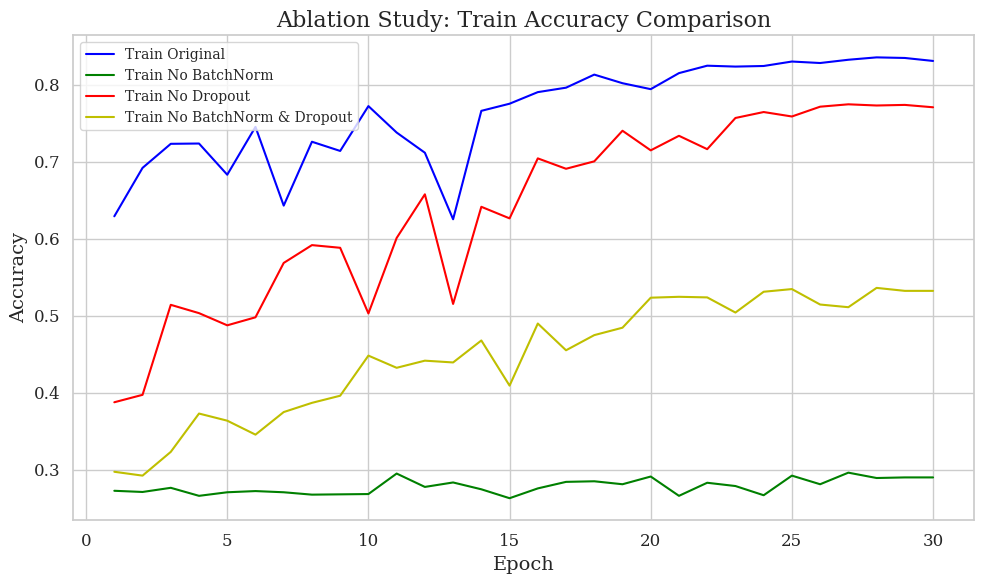

In [18]:
# Load the accuracies and losses for each model
df_original = extract_metrics(clf_original)
df_no_batch_norm = extract_metrics(clf_no_batch_norm)
df_no_dropout = extract_metrics(clf_no_dropout)
df_no_both = extract_metrics(clf_no_both)

# Plotting accuracy comparisons across models
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot the original model accuracies
ax1.plot(df_original.index, df_original['train_accuracy'],'b-',label='Train Original')

# Plot the no batch normalization model accuracies
ax1.plot(df_no_batch_norm.index, df_no_batch_norm['train_accuracy'], 'g-', label='Train No BatchNorm')

# Plot the no dropout model accuracies
ax1.plot(df_no_dropout.index, df_no_dropout['train_accuracy'], 'r-', label='Train No Dropout')

# Plot the no batch normalization + no dropout model accuracies
ax1.plot(df_no_both.index, df_no_both['train_accuracy'], 'y-', label='Train No BatchNorm & Dropout')

# Set labels and title
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.set_title('Ablation Study: Train Accuracy Comparison', fontsize=16)
ax1.legend(loc='best', fontsize=10)

# Customize ticks and grid
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True)

plt.tight_layout()
plt.show()


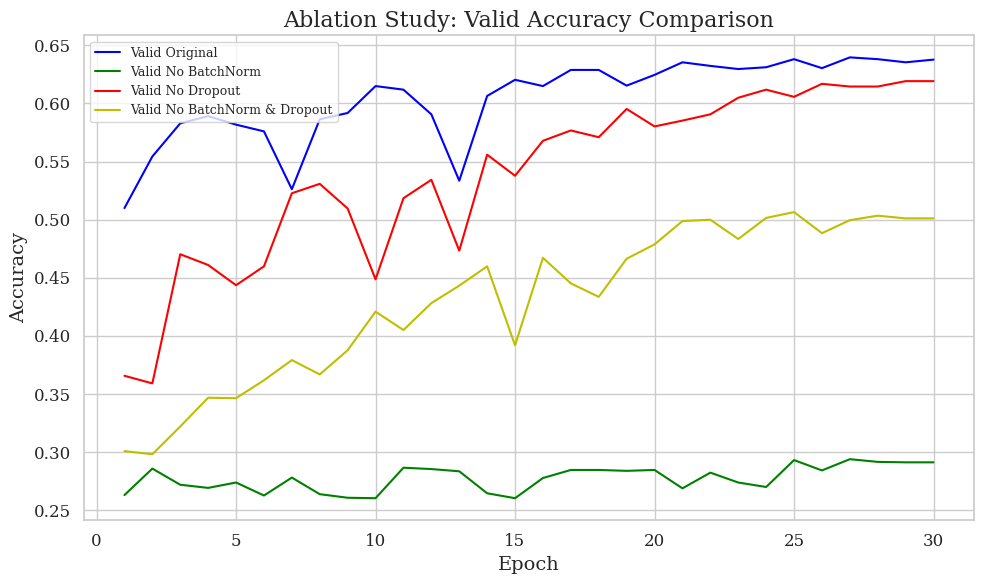

In [21]:
# Plotting accuracy comparisons across models
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the original model accuracies
ax1.plot(df_original.index, df_original['valid_accuracy'], 'b-', label='Valid Original')
ax1.plot(df_no_batch_norm.index, df_no_batch_norm['valid_accuracy'], 'g-', label='Valid No BatchNorm')
ax1.plot(df_no_dropout.index, df_no_dropout['valid_accuracy'], 'r-', label='Valid No Dropout')
ax1.plot(df_no_both.index, df_no_both['valid_accuracy'], 'y-', label='Valid No BatchNorm & Dropout')

ax1.set_xlabel('Epoch',fontsize=14)
ax1.set_ylabel('Accuracy',fontsize=14)
ax1.set_title('Ablation Study: Valid Accuracy Comparison',fontsize=16)
ax1.legend(loc='upper left',fontsize=9)

# Customize ticks and grid
ax1.tick_params(axis='x',labelsize=12)
ax1.tick_params(axis='y',labelsize=12)
ax1.grid(True)

plt.tight_layout()
plt.show()
